Note:
Today's lecture is from Jake VanderPlas' [Python Data Science Handbook](https://jakevdp.github.io/PythonDataScienceHandbook/).
- 
# Piviot Tables

[Wikipedia](https://en.wikipedia.org/wiki/Pivot_table) definition ... 

>A pivot table is a table of statistics that summarizes the data of a more extensive table (such as from a database, spreadsheet, or business intelligence program). This summary might include sums, averages, or other statistics, which the pivot table groups together in a meaningful way.

> Pivot tables are a technique in data processing. They arrange and rearrange (or "pivot") statistics in order to draw attention to useful information. 

- Takes column-wise data as input
- Groups the entries into a **two-dimensional table** providing a multidimensional summarization of the data
- **Pivot tables can be thought of as a *multidimensional* version of [groupBy](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html) aggregation.**

>A groupby operation involves some combination of splitting the object, applying a function, and combining the results. This can be used to group large amounts of data and compute operations on these groups.

  - Split and combine within split-apply-combine happen across a **two-dimensional** grid

## Motivating Pivot Tables
Using *Titanic* passengers data from the Seaborn library

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
titanic = sns.load_dataset('titanic')

In [ ]:
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


## Pivot Tables by Hand

Looking at the survival rate by gender.

In [ ]:
titanic.groupby('sex')[['survived']].mean()

,survived
sex,
female,0.742038
male,0.188908


- Three of four females on board survived.
- Only one in five males survived. 

### Taking it deeper
- *Group by* gender, class
- *Select* survival,
- *Appy* a mean aggregate
- *Combine* the resulting groups
- *Unstack* hierachical index to reveal the hidden multidimentionality. 

In [ ]:
titanic.groupby(['sex', 'class'])['survived'].aggregate('mean').unstack()

class,First,Second,Third
sex,,,
female,0.968085,0.921053,0.500000
male,0.368852,0.157407,0.135447


#### Let's unpack

- groupby(['sex', 'class']) returns pandas.DataFrameGroupby object
- groupby(['sex', 'class'])['survived'] returns SeriesGroupBy

In [ ]:
titanic.groupby(['sex', 'class'])['survived']

The result of applying ``aggregate`` method 

In [ ]:
titanic.groupby(['sex', 'class'])['survived'].aggregate('mean')

sex     class 
female  First     0.968085
        Second    0.921053
        Third     0.500000
male    First     0.368852
        Second    0.157407
        Third     0.135447
Name: survived, dtype: float64

``groupy`` on multiple columns creates a ``MultiIndex``

In [ ]:
titanic.groupby(['sex', 'class'])['survived'].aggregate('mean').index

MultiIndex([('female',  'First'),
            ('female', 'Second'),
            ('female',  'Third'),
            (  'male',  'First'),
            (  'male', 'Second'),
            (  'male',  'Third')],
           names=['sex', 'class'])

Compare the result of using only a single column (below) for the ``groupby`` operation with that of using multiple columns (above).

In [ ]:
titanic.groupby(['sex'])['survived'].aggregate('mean').index

Index(['female', 'male'], dtype='object', name='sex')

Getting back to the sample code ... 

We learned from the last lecture, ``unstack`` creates wider form of the data.
- The inner most (last) row index becomes the innermost column index

In [ ]:
titanic.groupby(['sex', 'class'])['survived'].aggregate('mean')

sex     class 
female  First     0.968085
        Second    0.921053
        Third     0.500000
male    First     0.368852
        Second    0.157407
        Third     0.135447
Name: survived, dtype: float64

In [ ]:
titanic.groupby(['sex', 'class'])['survived'].aggregate('mean').unstack()

class,First,Second,Third
sex,,,
female,0.968085,0.921053,0.500000
male,0.368852,0.157407,0.135447


## Pivot Table Syntax

The manual approach of using ``groupby`` allows us to have better understanding of how gender and class affected the survival. However, the code becomes more complicated. 

Below example is the same as the above sample (manual). It uses [DataFrame.pivot_table()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.pivot_table.html) method.

> DataFrame.pivot_table(self, values=None, index=None, columns=None, aggfunc='mean', fill_value=None, margins=False, dropna=True, margins_name='All', observed=False) → 'DataFrame'[source]

>    Create a spreadsheet-style pivot table as a DataFrame.

>    The levels in the pivot table will be stored in MultiIndex objects (hierarchical indexes) on the index and columns of the result DataFrame.

In [ ]:
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [ ]:
titanic.pivot_table('survived', index='sex', columns='class')

class,First,Second,Third
sex,,,
female,0.968085,0.921053,0.500000
male,0.368852,0.157407,0.135447


The resulting table using pivot_table is more readable and produces the same result as the ``groupby`` approach.

### Multi-level pivot tables

Grouping in pivot tables can be specified with multiple levels

First, on pd.cut() method ...

[pandas.cut()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html)

> pandas.cut(x, bins, right: bool = True, labels=None, retbins: bool = False, precision: int = 3, include_lowest: bool = False, duplicates: str = 'raise')[source]

>    Bin values into discrete intervals.

>    Use cut when you need to segment and sort data values into bins. This function is also useful for going from a continuous variable to a categorical variable. For example, cut could convert ages to groups of age ranges. Supports binning into an equal number of bins, or a pre-specified array of bins.

For more info, refer to this [article](https://pbpython.com/pandas-qcut-cut.html).

``pd.cut()`` returns a [pd.Categorical](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Categorical.html) object. 

In [ ]:
age = pd.cut(titanic['age'], [0, 18, 80])
age

0      (18.0, 80.0]
1      (18.0, 80.0]
2      (18.0, 80.0]
3      (18.0, 80.0]
4      (18.0, 80.0]
           ...     
886    (18.0, 80.0]
887    (18.0, 80.0]
888             NaN
889    (18.0, 80.0]
890    (18.0, 80.0]
Name: age, Length: 891, dtype: category
Categories (2, interval[int64]): [(0, 18] < (18, 80]]

In [ ]:
titanic.pivot_table('survived', ['sex', age], 'class')

class               First    Second     Third
sex    age                                   
female (0, 18]   0.909091  1.000000  0.511628
       (18, 80]  0.972973  0.900000  0.423729
male   (0, 18]   0.800000  0.600000  0.215686
       (18, 80]  0.375000  0.071429  0.133663

[pd.qcut](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.qcut.html)

>pandas.qcut(x, q, labels=None, retbins: bool = False, precision: int = 3, duplicates: str = 'raise')[source]

>    Quantile-based discretization function.

>    Discretize variable into equal-sized buckets based on rank or based on sample quantiles. For example 1000 values for 10 quantiles would produce a Categorical object indicating quantile membership for each data point.

In [ ]:
fare = pd.qcut(titanic['fare'], 2)
fare

0       (-0.001, 14.454]
1      (14.454, 512.329]
2       (-0.001, 14.454]
3      (14.454, 512.329]
4       (-0.001, 14.454]
             ...        
886     (-0.001, 14.454]
887    (14.454, 512.329]
888    (14.454, 512.329]
889    (14.454, 512.329]
890     (-0.001, 14.454]
Name: fare, Length: 891, dtype: category
Categories (2, interval[float64]): [(-0.001, 14.454] < (14.454, 512.329]]

In [ ]:
titanic.pivot_table('survived', ['sex', age], [fare, 'class'])

fare            (-0.001, 14.454]                     (14.454, 512.329]  \
class                      First    Second     Third             First   
sex    age                                                               
female (0, 18]               NaN  1.000000  0.714286          0.909091   
       (18, 80]              NaN  0.880000  0.444444          0.972973   
male   (0, 18]               NaN  0.000000  0.260870          0.800000   
       (18, 80]              0.0  0.098039  0.125000          0.391304   

fare                                 
class              Second     Third  
sex    age                           
female (0, 18]   1.000000  0.318182  
       (18, 80]  0.914286  0.391304  
male   (0, 18]   0.818182  0.178571  
       (18, 80]  0.030303  0.192308

### Additional pivot table options

- ``aggfunc`` argument controls the type of aggregation applied. The default is *mean*.
  - Aggregation can be a string representing one of several choices including ``'sum'``, ``'mean'``, ``'count'``, ``'min'``, ``'max'``, etc. 
  - It can also be a function that implments an aggregation (`np.sum()`, `min()`, `sum()`, etc)
  - A dictionary mapping a column to desired option can be specified

>aggfunc: function, list of functions, dict, default numpy.mean

>    If list of functions passed, the resulting pivot table will have hierarchical columns whose top level are the function names (inferred from the function objects themselves) If dict is passed, the key is column to aggregate and value is function or list of functions.


In [ ]:
titanic

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S,Second,man,True,NaN,Southampton,no,True
887,1,1,female,19.0,0,0,30.0000,S,First,woman,False,B,Southampton,yes,True
888,0,3,female,NaN,1,2,23.4500,S,Third,woman,False,NaN,Southampton,no,False
889,1,1,male,26.0,0,0,30.0000,C,First,man,True,C,Cherbourg,yes,True


In [ ]:
titanic.pivot_table(index='sex', columns='class',
                    aggfunc={'survived':sum, 'fare':'mean'})

fare                       survived             
class        First     Second      Third    First Second Third
sex                                                           
female  106.125798  21.970121  16.118810       91     70    72
male     67.226127  19.741782  12.661633       45     17    47

Computing totals along each grouping using ``margins`` keyword.

In [ ]:
titanic.pivot_table('survived', index='sex', columns='class', margins=True)

class,First,Second,Third,All
sex,,,,
female,0.968085,0.921053,0.500000,0.742038
male,0.368852,0.157407,0.135447,0.188908
All,0.629630,0.472826,0.242363,0.383838


### Example: Birthrate Data

In [ ]:
births = pd.read_csv('https://raw.githubusercontent.com/jakevdp/data-CDCbirths/master/births.csv ')

In [ ]:
births.head()

,year,month,day,gender,births
0,1969,1,1.0,F,4046
1,1969,1,1.0,M,4440
2,1969,1,2.0,F,4454
3,1969,1,2.0,M,4548
4,1969,1,3.0,F,4548


Adding a decade column and looking at male and female births as a function of decade:

In [ ]:
births['decade'] = 10 * (births['year'] // 10)
births.pivot_table('births', index='decade', columns='gender', aggfunc='sum')

gender,F,M
decade,,
1960,1753634,1846572
1970,16263075,17121550
1980,18310351,19243452
1990,19479454,20420553
2000,18229309,19106428


Male births outnumber female births. 
Using built-in plotting tools in Pandas to visualize the total number of births. 

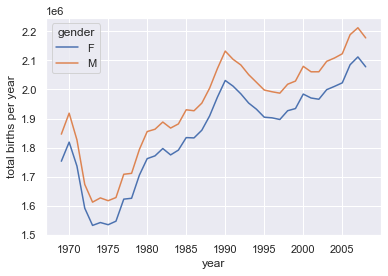

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
sns.set()  # use Seaborn styles
births.pivot_table('births', index='year', columns='gender', aggfunc='sum').plot()
plt.ylabel('total births per year');


Breaking it apart ... 


In [ ]:
births.head()

,year,month,day,gender,births,decade
0,1969,1,1.0,F,4046,1960
1,1969,1,1.0,M,4440,1960
2,1969,1,2.0,F,4454,1960
3,1969,1,2.0,M,4548,1960
4,1969,1,3.0,F,4548,1960


In [ ]:
births.pivot_table('births', index='year', columns='gender', aggfunc='sum')

gender,F,M
year,,
1969,1753634,1846572
1970,1819164,1918636
1971,1736774,1826774
1972,1592347,1673888
1973,1533102,1613023
1974,1543005,1627626
1975,1535546,1618010
1976,1547613,1628863
1977,1623363,1708796


# Vectorized String Operations

Pandas provides a set of *vectorized string operations* for munging required when working with real-world text data. 

For more details, refer to ['Working with text data'](https://pandas.pydata.org/pandas-docs/stable/user_guide/text.html).

## Introducing Pandas String Operations

Revising *vectorization* of operations

In [ ]:
import numpy as np
x = np.array([2, 3, 5, 7, 11, 13])
x * 2

array([ 4,  6, 10, 14, 22, 26])

Such operation does not exist for the string type.

In [ ]:
data = ['peter', 'Paul', 'MARY', 'gUIDO']
[s.capitalize() for s in data]

['Peter', 'Paul', 'Mary', 'Guido']

In [ ]:
try:
    data = ['peter', 'Paul', None, 'MARY', 'gUIDO']
    [s.capitalize() for s in data]
except AttributeError as e:
    print(e)

'NoneType' object has no attribute 'capitalize'


Pandas provides a capability to vectorize string operations and for handling missing data via the `str` attribute of Pandas Series and Index objects containing strings. 

In [ ]:
import pandas as pd
names = pd.Series(data)
names

0    peter
1     Paul
2     None
3     MARY
4    gUIDO
dtype: object

**Notice that the missing value is skipped over.**

In [ ]:
names.str.capitalize()

0    Peter
1     Paul
2     None
3     Mary
4    Guido
dtype: object

## Tables of Pandas String Methods


In [ ]:
monte = pd.Series(['Graham Chapman', 'John Cleese', 'Terry Gilliam',
                   'Eric Idle', 'Terry Jones', 'Michael Palin'])

### Methods similar to Python string methods

List of Pandas ``str`` vectorized string method:  

|             |                  |                  |                  |
|-------------|------------------|------------------|------------------|
|``len()``    | ``lower()``      | ``translate()``  | ``islower()``    | 
|``ljust()``  | ``upper()``      | ``startswith()`` | ``isupper()``    | 
|``rjust()``  | ``find()``       | ``endswith()``   | ``isnumeric()``  | 
|``center()`` | ``rfind()``      | ``isalnum()``    | ``isdecimal()``  | 
|``zfill()``  | ``index()``      | ``isalpha()``    | ``split()``      | 
|``strip()``  | ``rindex()``     | ``isdigit()``    | ``rsplit()``     | 
|``rstrip()`` | ``capitalize()`` | ``isspace()``    | ``partition()``  | 
|``lstrip()`` |  ``swapcase()``  |  ``istitle()``   | ``rpartition()`` |


In [ ]:
monte.str.lower()

0    graham chapman
1       john cleese
2     terry gilliam
3         eric idle
4       terry jones
5     michael palin
dtype: object

In [ ]:
monte.str.len()

0    14
1    11
2    13
3     9
4    11
5    13
dtype: int64

In [ ]:
monte.str.startswith('T')

0    False
1    False
2     True
3    False
4     True
5    False
dtype: bool

In [ ]:
monte.str.split()

0    [Graham, Chapman]
1       [John, Cleese]
2     [Terry, Gilliam]
3         [Eric, Idle]
4       [Terry, Jones]
5     [Michael, Palin]
dtype: object

### Methods using regular expressions

Methods that accept regular expressions and follow the API conventions of Python's built-in `re` module:  

| Method | Description |
|--------|-------------|
| ``match()`` | Call ``re.match()`` on each element, returning a boolean. |
| ``extract()`` | Call ``re.match()`` on each element, returning matched groups as strings.|
| ``findall()`` | Call ``re.findall()`` on each element |
| ``replace()`` | Replace occurrences of pattern with some other string|
| ``contains()`` | Call ``re.search()`` on each element, returning a boolean |
| ``count()`` | Count occurrences of pattern|
| ``split()``   | Equivalent to ``str.split()``, but accepts regexps |
| ``rsplit()`` | Equivalent to ``str.rsplit()``, but accepts regexps |


For a reference on regular expression, checkout this [website](https://www.regular-expressions.info/reference.html). 

Extracting the first name from each string. 

In [ ]:
monte.str.extract('([A-Za-z]+)', expand=False)

0     Graham
1       John
2      Terry
3       Eric
4      Terry
5    Michael
dtype: object

Finding all names that start and end with a consonant.  

Note: `^` marks the start of the string, and `$` marks the end of the string. 

In [ ]:
monte.str.findall(r'^[^AEIOU].*[^aeiou]$')

0    [Graham Chapman]
1                  []
2     [Terry Gilliam]
3                  []
4       [Terry Jones]
5     [Michael Palin]
dtype: object

### Miscellaneous methods

| Method | Description |
|--------|-------------|
| ``get()`` | Index each element |
| ``slice()`` | Slice each element|
| ``slice_replace()`` | Replace slice in each element with passed value|
| ``cat()``      | Concatenate strings|
| ``repeat()`` | Repeat values |
| ``normalize()`` | Return Unicode form of string |
| ``pad()`` | Add whitespace to left, right, or both sides of strings|
| ``wrap()`` | Split long strings into lines with length less than a given width|
| ``join()`` | Join strings in each element of the Series with passed separator|
| ``get_dummies()`` | extract dummy variables as a dataframe |


In [ ]:
monte.str.slice(0, 3)

0    Gra
1    Joh
2    Ter
3    Eri
4    Ter
5    Mic
dtype: object

In [ ]:
monte.str[0:3]

0    Gra
1    Joh
2    Ter
3    Eri
4    Ter
5    Mic
dtype: object

In [ ]:
monte.str.get(1)

0    r
1    o
2    e
3    r
4    e
5    i
dtype: object

In [ ]:
monte.str[1]

0    r
1    o
2    e
3    r
4    e
5    i
dtype: object

In [ ]:
monte.str.split().str.get(-1)

0    Chapman
1     Cleese
2    Gilliam
3       Idle
4      Jones
5      Palin
dtype: object

#### Indicator variables

`get_dummies()` method - useful when the data has a column containing coded indicator. e.g. dataset that contains information in the form of codes:
- A="born in America," B="born in the United Kingdom," C="likes cheese," D="likes spam":

In [ ]:
full_monte = pd.DataFrame({'name': monte,
                           'info': ['B|C|D', 'B|D', 'A|C',
                                    'B|D', 'B|C', 'B|C|D']})
full_monte

,name,info
0,Graham Chapman,B|C|D
1,John Cleese,B|D
2,Terry Gilliam,A|C
3,Eric Idle,B|D
4,Terry Jones,B|C
5,Michael Palin,B|C|D


The `get_dummies()` method splits the indicator variables into a DataFrame

In [ ]:
full_monte['info'].str.get_dummies('|')

,A,B,C,D
0,0,1,1,1
1,0,1,0,1
2,1,0,1,0
3,0,1,0,1
4,0,1,1,0
5,0,1,1,1


# Working with Time Series

Pandas provides a extensive tools for working with [time series data](https://en.wikipedia.org/wiki/Time_series).

>A time series is a series of data points indexed (or listed or graphed) in time order. Most commonly, a time series is a sequence taken at successive equally spaced points in time. Thus it is a sequence of discrete-time data. Examples of time series are heights of ocean tides, counts of sunspots, and the daily closing value of the Dow Jones Industrial Average. 

Terms:
- *Time stapms* particular moment in time
- *Time intervals* (*periods*) length of a time between a particular beginning and end point
- *Time deltas (*durations*) an exact length of time

## Datas and Times in Python
### Native Python dates and times

`datetime` ([built-in](https://docs.python.org/3/library/datetime.html)) and `dateutil` ([third-party](http://labix.org/python-dateutil))

In [ ]:
from datetime import datetime
datetime(year=2015, month=7, day=4)

datetime.datetime(2015, 7, 4, 0, 0)

Using `dateutil` module, dates can be parsed using a variety of string formats.

In [ ]:
from dateutil import parser
date = parser.parse("4th of July, 2015")
date

datetime.datetime(2015, 7, 4, 0, 0)

Using format codes to get different parts of the date. 

In [ ]:
date.strftime('%A')

'Saturday'

For a complete list of format codes, refer [here](https://docs.python.org/3/library/datetime.html#strftime-and-strptime-behavior).

`datetime` and `dateutil`
- Pros: flexibility and easy syntax
- Cons: performance on a large arrays of dates and times.  

### Typed arrays of times: NumPy's `datetime64`
`datatime64` dtype encodes dates as 64-bit integers
- Allows for the arrays of dates to be represented compactly.
- Requires a very specific input format

In [ ]:
import numpy as np
date = np.array('2015-07-04', dtype=np.datetime64)
date

array('2015-07-04', dtype='datetime64[D]')

Applying vectorized operation.  
- The uniform type of `datetime64` in NumPy allows for high performanance operations of the objects. 

In [ ]:
date + np.arange(12)

array(['2015-07-04', '2015-07-05', '2015-07-06', '2015-07-07',
       '2015-07-08', '2015-07-09', '2015-07-10', '2015-07-11',
       '2015-07-12', '2015-07-13', '2015-07-14', '2015-07-15'],
      dtype='datetime64[D]')

NumPy's `datetime64` and `timedelta64` are built on a *fundamental time unit*. 
- The objects are limited to 64-bit precision
- The range of encodable times is 2<sup>64</sup> times the fundamental unit
- NumPy will infer the desired unit from the input.

In [ ]:
np.datetime64('2015-07-04') # day-based datetime

numpy.datetime64('2015-07-04')

In [ ]:
np.datetime64('2015-07-04 12:00') # minute-based datetime

numpy.datetime64('2015-07-04T12:00')

Time zone is automatically set to the local time on the computer executing the code. 

In [ ]:
np.datetime64('2015-07-04 12:59:59.50', 'ns') # nanosecond-based time

numpy.datetime64('2015-07-04T12:59:59.500000000')

Available format codes and relative absolute timespans.

|Code    | Meaning     | Time span (relative) | Time span (absolute)   |
|--------|-------------|----------------------|------------------------|
| ``Y``  | Year	       | ± 9.2e18 years       | [9.2e18 BC, 9.2e18 AD] |
| ``M``  | Month       | ± 7.6e17 years       | [7.6e17 BC, 7.6e17 AD] |
| ``W``  | Week	       | ± 1.7e17 years       | [1.7e17 BC, 1.7e17 AD] |
| ``D``  | Day         | ± 2.5e16 years       | [2.5e16 BC, 2.5e16 AD] |
| ``h``  | Hour        | ± 1.0e15 years       | [1.0e15 BC, 1.0e15 AD] |
| ``m``  | Minute      | ± 1.7e13 years       | [1.7e13 BC, 1.7e13 AD] |
| ``s``  | Second      | ± 2.9e12 years       | [ 2.9e9 BC, 2.9e9 AD]  |
| ``ms`` | Millisecond | ± 2.9e9 years        | [ 2.9e6 BC, 2.9e6 AD]  |
| ``us`` | Microsecond | ± 2.9e6 years        | [290301 BC, 294241 AD] |
| ``ns`` | Nanosecond  | ± 292 years          | [ 1678 AD, 2262 AD]    |
| ``ps`` | Picosecond  | ± 106 days           | [ 1969 AD, 1970 AD]    |
| ``fs`` | Femtosecond | ± 2.6 hours          | [ 1969 AD, 1970 AD]    |
| ``as`` | Attosecond  | ± 9.2 seconds        | [ 1969 AD, 1970 AD]    |


For more discussion, refer to NumPy's Datetimes and Timedeltas [documentation](https://docs.scipy.org/doc/numpy/reference/arrays.datetime.html). 

### Dates and times in pandas: best of both worlds

Pandas provides `Timestamp` object
- Combines the ease-of-use of `datetime` and `dateutil` with the efficient storage and vectorized interface of `numpy.datetime64`. 
- Using Timestamp objects, Pandas can construct a DatetimeIndex used to index data in a `Series` or `DataFrame`. 

In [ ]:
import pandas as pd
date = pd.to_datetime("4th of July, 2015")
date

Timestamp('2015-07-04 00:00:00')

In [ ]:
date.strftime('%A')

'Saturday'

In [ ]:
date + pd.to_timedelta(np.arange(12), 'D')

DatetimeIndex(['2015-07-04', '2015-07-05', '2015-07-06', '2015-07-07',
               '2015-07-08', '2015-07-09', '2015-07-10', '2015-07-11',
               '2015-07-12', '2015-07-13', '2015-07-14', '2015-07-15'],
              dtype='datetime64[ns]', freq=None)

## Pandas Time Series: Indexing by Time

Indexing data by timestamps

In [ ]:
index = pd.DatetimeIndex(['2014-07-04', '2014-08-04',
                          '2015-07-04', '2015-08-04'])
data = pd.Series([0, 1, 2, 3], index=index)
data

2014-07-04    0
2014-08-04    1
2015-07-04    2
2015-08-04    3
dtype: int64

Using the `Series` indexing patterns

In [ ]:
data['2014-07-04':'2015-07-04']

2014-07-04    0
2014-08-04    1
2015-07-04    2
dtype: int64

Special date-only indexing operations
- Passing a year to obtain a slice of all data from that year.

In [ ]:
data['2015']

2015-07-04    2
2015-08-04    3
dtype: int64

# Pandas Time Series Data Structures

- *time stamps*, Pandas provides the `Timestamp` type
  - Replacement for Python's native `datetime`.
  - Based on efficient `numpy.datetime64` data type. 
  - `DatetimeIndex` is the associated index structure. 
  - Use the `pd.to_datetime()` function to parse a wide variety of formats.
- *time Periods*, Pandas provides the `Period` type.
  - Encodes a fixed-frequency interval based on `numpy.datetime64`.
  - Associated index structure is `PeriodIndex`.
  - `DatatimeIndex` can be converted to a `PeriodIndex` with the `to_period()`.
- *time deltas*/*durations*, Pandas provides the `Timedelta` type.
  - Replacement for Python's native `datetime.timedelta` based on `numpy.timedelta64`
  - Associated index structure is `TimedeltaIndex`.

In [ ]:
dates = pd.to_datetime([datetime(2015, 7, 3), '4th of July, 2015',
                       '2015-Jul-6', '07-07-2015', '20150708'])
dates

DatetimeIndex(['2015-07-03', '2015-07-04', '2015-07-06', '2015-07-07',
               '2015-07-08'],
              dtype='datetime64[ns]', freq=None)

In [ ]:
dates.to_period('D') # 'D' to indicate daily frequency

PeriodIndex(['2015-07-03', '2015-07-04', '2015-07-06', '2015-07-07',
             '2015-07-08'],
            dtype='period[D]', freq='D')

In [ ]:
dates - dates[0]

TimedeltaIndex(['0 days', '1 days', '3 days', '4 days', '5 days'], dtype='timedelta64[ns]', freq=None)

## Regular sequences: `pd.date_range()`

Creation of regular date sequences
- `pd.date_range()` for timestamps
- `pd.period_range()` for periods
- `pd.timedelta_range()` for time deltas

In [ ]:
pd.date_range('2015-07-03', '2015-07-10')

DatetimeIndex(['2015-07-03', '2015-07-04', '2015-07-05', '2015-07-06',
               '2015-07-07', '2015-07-08', '2015-07-09', '2015-07-10'],
              dtype='datetime64[ns]', freq='D')

In [ ]:
pd.date_range('2015-07-03', periods=8)

DatetimeIndex(['2015-07-03', '2015-07-04', '2015-07-05', '2015-07-06',
               '2015-07-07', '2015-07-08', '2015-07-09', '2015-07-10'],
              dtype='datetime64[ns]', freq='D')

In [ ]:
pd.date_range('2015-07-03', periods=8, freq='H')

DatetimeIndex(['2015-07-03 00:00:00', '2015-07-03 01:00:00',
               '2015-07-03 02:00:00', '2015-07-03 03:00:00',
               '2015-07-03 04:00:00', '2015-07-03 05:00:00',
               '2015-07-03 06:00:00', '2015-07-03 07:00:00'],
              dtype='datetime64[ns]', freq='H')

In [ ]:
pd.period_range('2015-07', periods=8, freq='M')

PeriodIndex(['2015-07', '2015-08', '2015-09', '2015-10', '2015-11', '2015-12',
             '2016-01', '2016-02'],
            dtype='period[M]', freq='M')

In [ ]:
pd.timedelta_range(0, periods=10, freq='H')

TimedeltaIndex(['00:00:00', '01:00:00', '02:00:00', '03:00:00', '04:00:00',
                '05:00:00', '06:00:00', '07:00:00', '08:00:00', '09:00:00'],
               dtype='timedelta64[ns]', freq='H')

### Frequencies and Offsets  

| Code   | Description         | Code   | Description          |
|--------|---------------------|--------|----------------------|
| ``D``  | Calendar day        | ``B``  | Business day         |
| ``W``  | Weekly              |        |                      |
| ``M``  | Month end           | ``BM`` | Business month end   |
| ``Q``  | Quarter end         | ``BQ`` | Business quarter end |
| ``A``  | Year end            | ``BA`` | Business year end    |
| ``H``  | Hours               | ``BH`` | Business hours       |
| ``T``  | Minutes             |        |                      |
| ``S``  | Seconds             |        |                      |
| ``L``  | Milliseonds         |        |                      |
| ``U``  | Microseconds        |        |                      |
| ``N``  | nanoseconds         |        |                      |


Monthly, quarterly, and annual frequencies are marked at the end of the specified period. Adding `s` suffix will be marked at the beginning.  

| Code    | Description            || Code    | Description            |
|---------|------------------------||---------|------------------------|
| ``MS``  | Month start            ||``BMS``  | Business month start   |
| ``QS``  | Quarter start          ||``BQS``  | Business quarter start |
| ``AS``  | Year start             ||``BAS``  | Business year start    |

Quarterly or annual code
- ``Q-JAN``, ``BQ-FEB``, ``QS-MAR``, ``BQS-APR``, etc.
- ``A-JAN``, ``BA-FEB``, ``AS-MAR``, ``BAS-APR``, etc.

Split-point of weekly frequency
- ``W-SUN``, ``W-MON``, ``W-TUE``, ``W-WED``, etc.

These short codes refer to specific instances of Pandas time series offsets found in the `pd.tseries.offsets`.

In [ ]:
pd.timedelta_range(0, periods=9, freq="2H30T")

TimedeltaIndex(['00:00:00', '02:30:00', '05:00:00', '07:30:00', '10:00:00',
                '12:30:00', '15:00:00', '17:30:00', '20:00:00'],
               dtype='timedelta64[ns]', freq='150T')

In [ ]:
from pandas.tseries.offsets import BDay
pd.date_range('2015-07-01', periods=5, freq=BDay())

DatetimeIndex(['2015-07-01', '2015-07-02', '2015-07-03', '2015-07-06',
               '2015-07-07'],
              dtype='datetime64[ns]', freq='B')

## Resampling, Shifting, and Windowing

In [ ]:
!pip install pandas-datareader

In [ ]:
from pandas_datareader import data

goog = data.DataReader('GOOG', start='2004', end='2016',
                       data_source='yahoo')
goog.head()

c:\users\dongh\documents\venv\jupyter_lab\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2004-08-19,51.835709,47.800831,49.813286,49.982655,44871300.0,49.982655
2004-08-20,54.336334,50.062355,50.316402,53.952770,22942800.0,53.952770
2004-08-23,56.528118,54.321388,55.168217,54.495735,18342800.0,54.495735
2004-08-24,55.591629,51.591621,55.412300,52.239193,15319700.0,52.239193
2004-08-25,53.798351,51.746044,52.284027,52.802086,9232100.0,52.802086


In [ ]:
goog = goog['Close']

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set()

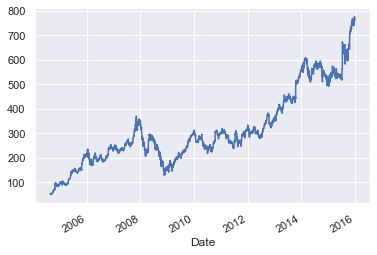

In [ ]:
goog.plot()

#### Resampling and converting frequencies

Resampling at a higher or lower frequency can be done by [resample()](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#resampling) or `asfreq()` methods. 

- `resample()` is *data aggregation*
- `asfreq()` is a *data selection*

Refer [here](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases) for the definitions of resampling rule strings. 

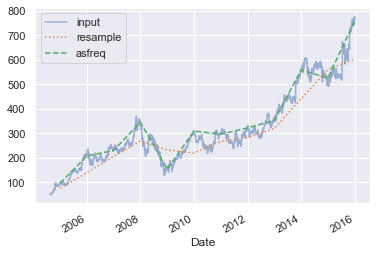

In [ ]:
goog.plot(alpha=0.5, style='-')
goog.resample('BA').mean().plot(style=':')
goog.asfreq('BA').plot(style='--'); # business year end frequency
plt.legend(['input', 'resample', 'asfreq'],
           loc='upper left');

### Time-shifts
Pandas has two methods for shifting of data in time: 
- `shift()`, shifts data
- `tshift()`, shifts the index
- The shift is specified in multiples of the frequency.

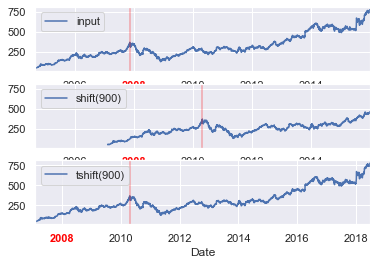

In [ ]:
fig, ax = plt.subplots(3, sharey=True)

# apply a frequency to the data
goog = goog.asfreq('D', method='pad')

goog.plot(ax=ax[0])
goog.shift(900).plot(ax=ax[1])
goog.tshift(900).plot(ax=ax[2])

# legends and annotations
local_max = pd.to_datetime('2007-11-05')
offset = pd.Timedelta(900, 'D')

ax[0].legend(['input'], loc=2)
ax[0].get_xticklabels()[2].set(weight='heavy', color='red')
ax[0].axvline(local_max, alpha=0.3, color='red')

ax[1].legend(['shift(900)'], loc=2)
ax[1].get_xticklabels()[2].set(weight='heavy', color='red')
ax[1].axvline(local_max + offset, alpha=0.3, color='red')

ax[2].legend(['tshift(900)'], loc=2)
ax[2].get_xticklabels()[1].set(weight='heavy', color='red')
ax[2].axvline(local_max + offset, alpha=0.3, color='red');

### Rolling windows
Rolling() method of `Series` and `DataFrame` objects provide [rolling statistics](https://www.mathworks.com/help/econ/rolling-window-estimation-of-state-space-models.html). This works similarly to `groupby` operation. 

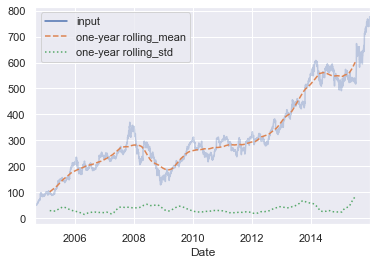

In [ ]:
rolling = goog.rolling(365, center=True)

data = pd.DataFrame({'input': goog,
                     'one-year rolling_mean': rolling.mean(),
                     'one-year rolling_std': rolling.std()})
ax = data.plot(style=['-', '--', ':'])
ax.lines[0].set_alpha(0.3)

# High-Performance Pandas

`eval()` and `query()` functions allow Pandas to acces C-speed operations without allocating intermediate temporary objects. These functions rely on the [Fast numerical array expression evaluator for Python](https://github.com/pydata/numexpr), or Numexpr. 